<a href="https://colab.research.google.com/github/alexchen1999/covid-19-sample-strain-classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import sys
import pandas as pd
import re
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from Bio import SeqIO 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read pandas csv
df = pd.read_csv('/content/drive/My Drive/spike_seq_one_hots_1000.csv')
df.head()

,Accession,Seq,Label
0,MZ329246.1,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",Delta
1,OK373135.1,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",Gamma
2,OK249585.1,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",Delta
3,OK124413.1,"[[0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0], [...",Gamma
4,OK187748.1,"[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...",Delta


In [7]:
print(df['Seq'].shape)

(4000,)


In [9]:
def str2array(s):
    return np.array(json.loads(s))

df1=pd.read_csv('/content/drive/My Drive/spike_seq_one_hots_1000.csv', converters={'Seq': str2array})
print(df1.iloc[0]['Seq'])
print(type(df1.iloc[0]['Seq']))
print(df1.iloc[0]['Seq'].shape)
print(df1.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
<class 'numpy.ndarray'>
(3822, 4)
(4000, 3)


In [10]:
# Train Test Split
X = df1['Seq']
y = df1.iloc[:, 2:3]

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
   X, y, test_size=0.1, random_state=42)

train_label_encoder = LabelEncoder()
train_label_encoder.fit(train_labels)

test_label_encoder = LabelEncoder()
test_label_encoder.fit(test_labels)

train_inputs = train_inputs.to_numpy().tolist()
test_inputs = test_inputs.to_numpy().tolist()

train_inputs = torch.tensor(train_inputs).type(torch.LongTensor)
train_labels = torch.from_numpy(train_label_encoder.transform(train_labels))

test_inputs = torch.tensor(test_inputs)
test_labels = torch.from_numpy(test_label_encoder.transform(test_labels)).type(torch.LongTensor)

# print('train_inputs', train_inputs)
print('train_labels', train_labels)

print('train_inputs type', train_inputs.dtype)
print('train_labels type', train_labels.dtype)
print('train_inputs shape', train_inputs.shape)
print('train_labels shape', train_labels.shape)

# Load data to PyTorch DataLoader
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=40)
test_dataloader = DataLoader(test_dataset, batch_size=4)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_labels tensor([1, 0, 0,  ..., 1, 0, 0])
train_inputs type torch.int64
train_labels type torch.int64
train_inputs shape torch.Size([3600, 3822, 4])
train_labels shape torch.Size([3600])


In [11]:
# Training
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  ''' Trains a neural network. Returns a 2d numpy array, where every list 
  represents the losses per epoch.
  '''
  net.to(device)
  losses_per_epoch = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    print('epoch:', epoch)
    sum_loss = 0.0
    losses = []
    for i, batch in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device).long(), batch[1].to(device).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
    # print(len(losses))
    losses_per_epoch.append(np.mean(losses))
  return losses_per_epoch

In [22]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4908339/
# In-channels should be L * 4 where L is sequence length, 3822
# RGB is 3 * w * h

# nn.Conv1d() expects the input to be of the shape 
# [batch_size, input_channels, signal_length]

# in our case [40, 4, 3822]

# 100 sample experiment
ex_100 = [['in_channels_conv1', 'out_channels_conv1', 'in_channels_conv2', 'out_channels_conv2', 'in_channels_fc1', 'kernel_size', 'stride', ('train_acc'), ('test_acc')],
      [4, 4, 2, 2, 957, 2, 1, 0, (0.98055555), (0.825)], #1
      [4, 4, 2, 2, 955, 4, 1, 0, (0.96944444), (0.85)], #2
      [4, 4, 2, 2, 952, 8, 1, 0, (0.977777), (0.875)], #3
]

# 1000 sample experiment
ex = [['in_channels_conv1', 'out_channels_conv1', 'in_channels_conv2', 'out_channels_conv2', 'in_channels_fc1', 'kernel_size', 'stride', ('train_acc'), ('test_acc')],
      [4, 4, 2, 2, 957, 2, 1, 0, 0.9575*(3447/3600), 0.9525*(381/400)], #1
      [4, 4, 2, 2, 955, 4, 1, 0, 0.9772*(3518/3600), 0.98*(392/400)], #2
      [4, 4, 2, 2, 952, 8, 1, 0, 0.9888*(3560/3600), 0.985*(394/400)], #3
]

i = 3

print(ex[i][-3])

FEATURE_SIZE = ex[i][0]
print(FEATURE_SIZE)

class DSC_by_CNN(nn.Module):
    def __init__(self, feature_size):


        super(DSC_by_CNN, self).__init__()
        self.feature_size = feature_size

        self.conv1 = nn.Conv1d(in_channels=ex[i][0],
                               out_channels=ex[i][1], 
                               kernel_size=ex[i][5],
                               stride = ex[i][6],
                               padding = 1)
        self.conv2 = nn.Conv1d(in_channels=ex[i][2],
                               out_channels=ex[i][3], 
                               kernel_size=ex[i][5],
                               stride = ex[i][6],
                               padding = 1)


        # Activation
        self.act = nn.ReLU()

        # Pooling
        self.pool = nn.MaxPool2d(3, 2, 1)

        # fully connected layer
        self.fc1 = nn.Linear(ex[i][4], 100)

        # dropout
        self.drop = nn.Dropout(p=0.5)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        


    def forward(self, x):
        x = torch.tensor(x).to(torch.float32)

        # Permute shuffles dimensions. Do this to satisfy requirments of nn.Conv1d
        # Output shape: (b, embedded_dim, max_len)
        x = x.permute(0, 2, 1)

        # convolutional layer 1
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)

        # convolutional layer 2
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)

        # flattening
        x = x.view(-1, self.num_flat_features(x))

        # fully linear layer + dropout
        x = self.drop(x)
        # x = self.softm(x)
        x = self.fc1(x)

        return x

0
4


In [23]:
def accuracy(net, dataloader):
    '''
    Given a trained neural network and a dataloader, computes the accuracy.
    Arguments:
        net: a neural network
        dataloader: a dataloader
    Returns:
        fraction of examples classified correctly (float)
        number of correct examples (int)
        number of total examples (float)
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            input, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(input)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total, correct, total

def print_eval(net, train_dataloader, test_dataloader):
    '''
    Given a test and train data loader, prints the test and train accuracy and
    the number of examples they got right.
    RETURNS
        (train_acc, test_acc) results of running accuracy on the two dataloaders
    '''
    train_acc = accuracy(net, train_dataloader)
    test_acc = accuracy(net, test_dataloader)
    

    print("Train accuracy: " + str(train_acc[0]) + "\t(" + str(train_acc[1]) + "/" + str(train_acc[2]) + ")")
    print("Test accuracy: " + str(test_acc[0]) + "\t(" + str(test_acc[1]) + "/" + str(test_acc[2]) + ")")
          
    return train_acc, test_acc

def plot_losses(losses, smooth_val = None, title = ""):
    '''
    Plots the losses per epoch returned by the training function.
    Args:
        losses: a list of losses returned by train
        smooth_val: an optinal integer value if smoothing is desired
        title: a title for the graph
    '''
    # loss = np.mean(losses, axis = 1)
    epochs = [i for i in range(1, len(losses) + 1)]
    if smooth_val is not None:
        losses = smooth(losses, smooth_val)
    plt.plot(epochs, losses, marker="o", linestyle="dashed")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    

def smooth(x, size):
    '''
    Given an array, smooths it by some number size, to make it look less janky.
    '''
    return np.convolve(x, np.ones(size)/size, mode='same')

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
Train accuracy: 0.9

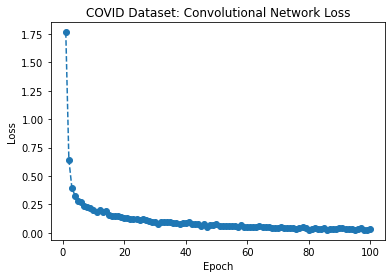

In [24]:
# Creating net and training

net = DSC_by_CNN(FEATURE_SIZE)
losses = train(net, train_dataloader, epochs=100, lr=0.01, decay = ex[i][-3])

# Evaluation
plot_losses(losses, title = "COVID Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()

In [ ]:
print(X)
print(X.loc[0])
print(y.loc[0])

0      [[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [...
1      [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...
2      [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
3      [[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
4      [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...
                             ...                        
395    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...
396    [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...
397    [[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
398    [[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
399    [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...
Name: Seq, Length: 400, dtype: object
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
Label    Delta
Name: 0, dtype: object


In [ ]:
print(train_dataset.__getitem__(0))
print(train_dataset.__getitem__(0)[0].dtype)

(tensor([[0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]), tensor(0))
torch.int64


In [ ]:
print(train_dataloader)

In [ ]:
ser = pd.Series([0, 1, 0])
print(ser.isna())

0    False
1    False
2    False
dtype: bool


# Resources/Errors Encountered:

- Load a list of numpy arrays to Pytorch TensorDataset: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
- https://stackoverflow.com/questions/72538897/runtimeerror-given-groups-1-weight-of-size-6-3-3-3-expected-input4-224/72547977
- RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte
- PyTorch Convolution `in_channels` and `out_channels` meaning? https://stackoverflow.com/questions/56652204/pytorch-convolution-in-channels-and-out-channels-meaning
- Torch nn Conv1D Example: https://www.tutorialexample.com/understand-torch-nn-conv1d-with-examples-pytorch-tutorial/
- `RuntimeError: Given groups=1, weight of size [15288, 15288, 6], expected input[40, 4, 3822] to have 15288 channels, but got 4 channels instead`
- `RuntimeError: expected scalar type Long but found Float`:
https://discuss.pytorch.org/t/runtimeerror-expected-scalar-type-long-but-found-float-conv1d/105249